In [1]:
import os

import torchvision.transforms as transforms
import torch.utils.data as data
import medmnist
from medmnist import INFO, Evaluator

from typing import Dict

import numpy
import numpy as np


/Users/manuel.pasieka/opt/miniconda3/envs/featurecloud/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download and visualize dataset

In [2]:
data_flag = 'chestmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
validation_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

Using downloaded and verified file: /Users/manuel.pasieka/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/manuel.pasieka/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/manuel.pasieka/.medmnist/chestmnist.npz


In [3]:
test_loader = data.DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)

Dataset contains 78468 Training Images with size 28x28
Dataset contains 22433 Testing Images with size 28x28
Dataset contains 11219 Validation Images with size 28x28


/Users/manuel.pasieka/opt/miniconda3/envs/featurecloud/lib/python3.10/site-packages/medmnist/utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


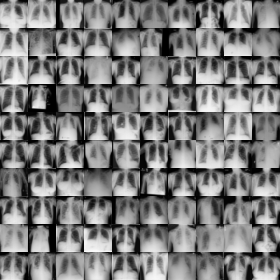

In [4]:
print(f'Dataset contains {train_dataset.imgs.shape[0]} Training Images with size {train_dataset.imgs.shape[1]}x{train_dataset.imgs.shape[2]}')
print(f'Dataset contains {test_dataset.imgs.shape[0]} Testing Images with size {test_dataset.imgs.shape[1]}x{test_dataset.imgs.shape[2]}')
print(f'Dataset contains {validation_dataset.imgs.shape[0]} Validation Images with size {validation_dataset.imgs.shape[1]}x{validation_dataset.imgs.shape[2]}')
train_dataset.montage(10)

# Split dataset for multiple clients

In [5]:
def split_data(ds : medmnist.dataset.ChestMNIST, nClients : int) -> Dict[int, Dict['str', numpy.ndarray]]:
    N = ds.imgs.shape[0]
    pN = N//nClients
    idx = np.random.permutation(N)
    pIdx = np.array_split(idx, nClients)

    dataset = {}
    for i in range(nClients):
        dataset[i] = {'imgs': ds.imgs[pIdx[i]], 'labels': ds.labels[pIdx[i]]}
    
    return dataset

In [6]:
nClients = 2

train_split = split_data(train_dataset, nClients)
test_split = split_data(test_dataset, nClients)
val_split = split_data(validation_dataset, nClients)

In [7]:
base_path = './client_data'
client_folders = [f'{base_path}/client_{i}' for i in range(1, 1+nClients)]
_ = [os.makedirs(p, exist_ok=True) for p in client_folders]

In [8]:
# Write all files for each client
for i in range(nClients):
    x_train_path = f'{client_folders[i]}/x_train.npy'
    np.save(x_train_path, train_split[i]['imgs'])
    
    y_train_path = f'{client_folders[i]}/y_train.npy'
    np.save(y_train_path, train_split[i]['labels'])
    
    x_test_path = f'{client_folders[i]}/x_test.npy'
    np.save(x_test_path, test_split[i]['imgs'])
    
    y_test_path = f'{client_folders[i]}/y_test.npy'
    np.save(y_test_path, test_split[i]['labels'])
    
    x_val_path = f'{client_folders[i]}/x_val.npy'
    np.save(x_val_path, val_split[i]['imgs'])
    
    y_val_path = f'{client_folders[i]}/y_val.npy'
    np.save(y_val_path, val_split[i]['labels']) 